<a href="https://colab.research.google.com/github/micah-shull/superstore/blob/main/010_superstore_clustering_prep_bin%26drop_columns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load & Process Data

In [10]:
# Import the script
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
import data_prep_utils as dpu
import data_visualization_utils as dvu

# Step 1: Load your dataset
try:
    data = pd.read_excel('sample-superstore.xls')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: File not found. Please check the file path.")
    exit()

# Step 2: Preprocess the data (derives metrics and standardizes categorical columns)
data = dpu.preprocess_data(data)

# Step 3: Add time-based columns
data = dpu.add_time_based_columns(data)

# Step 4: Convert appropriate columns to category and visualize
exclude_columns = ['Profit per Sub-Category', 'Quantity', 'Estimated Cost', 'Average Discount',
                   'Discount', 'Total Quantity', 'Profit Margin', 'Regional Market Share (%)', 'Profit per Category', 'Order Count']
data = dpu.convert_to_category_and_visualize(data, threshold=25, exclude_columns=exclude_columns)

# Step 5: Remove duplicates
data = dpu.remove_duplicates(data, subset=['Order ID', 'Customer ID'])

# Step 6: (Optional) Standardize specific columns if needed
columns_to_standardize = ['Region', 'Category', 'Sub-Category']
data = dpu.standardize_categorical_columns(data, columns_to_standardize)

# Step 7: Remove outliers in the 'Sales' column using Tukey's Fences
data, outliers = dpu.remove_outliers_tukey(data, column='Sales', plot=False)

# ✅ Efficient way to remove outliers for multiple columns
# columns_to_remove_outliers = ['Sales', 'Profit', 'Estimated Cost']

# for column in columns_to_remove_outliers:
#     data, _ = dpu.remove_outliers_tukey(data, column=column, plot=False)


# Create new column for Profit/Loss
data['PL'] = data['Profit'].apply(lambda x: 'Profit' if x > 0 else 'Loss')


# Check the updated dataset
data.info()

Dataset loaded successfully.
Removed 4985 duplicate rows.
Column: Sales
Lower Fence: -259.31, Upper Fence: 475.57
Original Dataset: 5009 rows
Non-Outliers: 4399 rows (87.82%)
Outliers: 610 rows (12.18%)
<class 'pandas.core.frame.DataFrame'>
Index: 4399 entries, 0 to 9993
Data columns (total 37 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Row ID                     4399 non-null   int64         
 1   Order ID                   4399 non-null   object        
 2   Order Date                 4399 non-null   datetime64[ns]
 3   Ship Date                  4399 non-null   datetime64[ns]
 4   Ship Mode                  4399 non-null   category      
 5   Customer ID                4399 non-null   object        
 6   Customer Name              4399 non-null   object        
 7   Segment                    4399 non-null   category      
 8   Country                    4399 non-null   category      
 9

### **📌 Binning Numeric Columns for Clustering**
Binning numeric values into **categories** can make clustering **more interpretable** while still preserving meaningful differences. Since I plan to **use numeric values as bin names**, we can create **custom bins** for key financial metrics.

---

### **🔹 Which Columns Should We Bin?**
Here's a breakdown of the numeric columns and whether they should be **binned or left continuous**:

| Column | Type | Bin? | Notes |
|---------|------|------|---------------------------|
| **Sales** | Monetary | ✅ | Helps group customers by spending habits |
| **Quantity** | Count | ❌ | Works better as a continuous variable |
| **Discount** | Percentage | ✅ | Helps categorize discount levels |
| **Profit** | Monetary | ✅ | Key business metric for segmentation |
| **Profit Margin** | Percentage | ✅ | Groups customers by profitability levels |
| **Estimated Cost** | Monetary | ✅ | Useful for cost-based segmentation |
| **Profitability Ratio** | Percentage | ✅ | Determines customer profitability trends |
| **Sales_Customer** | Monetary | ✅ | Captures customer-level total sales |
| **Profit_Customer** | Monetary | ✅ | Captures customer-level total profit |
| **Order Count** | Count | ❌ | Works better as a continuous variable |
| **Regional Market Share (%)** | Percentage | ❌ | Leave as continuous for now |

**✅ Decision**:  
- We should **bin**: `Sales`, `Discount`, `Profit`, `Profit Margin`, `Estimated Cost`, `Profitability Ratio`, `Sales_Customer`, `Profit_Customer`.  
- We should **keep continuous**: `Quantity`, `Order Count`, `Regional Market Share (%)` (for now).  



['Sales', 'Discount', 'Profit', 'Profit Margin', 'Estimated Cost', 'Profitability Ratio']


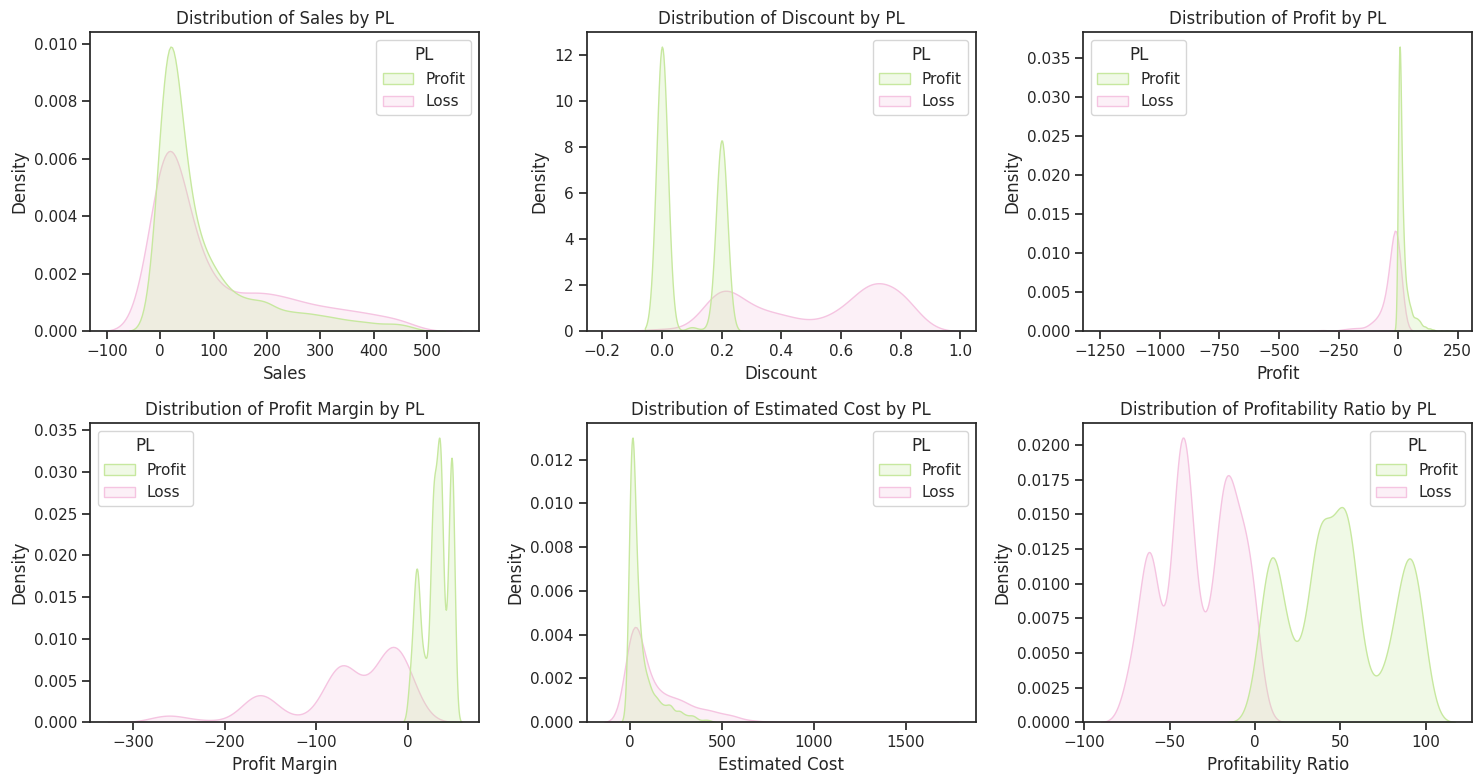

In [11]:
numeric_columns = data.select_dtypes(include='number').columns
exclude_columns = ['Row ID', 'Postal Code', 'Quantity', 'Order Count', 'Regional Market Share (%)', 'Sales_Customer', 'Profit_Customer']

# Filter out excluded columns
columns_to_bin = [col for col in numeric_columns if col not in exclude_columns]
print(columns_to_bin)

# Define final columns for KDE visualization
kde_columns = ['Sales', 'Discount', 'Profit', 'Profit Margin', 'Estimated Cost', 'Profitability Ratio']

sns.set_theme(style="ticks", context="notebook")
# Call function to plot
dvu.plot_kde_grid(data, kde_columns, hue="PL", grid_size=(2, 3))

In [6]:
data[columns_to_bin].describe()

,Sales,Discount,Profit,Profit Margin,Estimated Cost,Profitability Ratio
count,4399.000000,4399.000000,4399.000000,4399.000000,4399.000000,4399.000000
mean,87.185567,0.157631,10.015425,12.300484,77.170142,34.252028
std,106.600811,0.212619,48.997529,49.205450,110.521584,42.024310
min,0.556000,0.000000,-1181.282400,-275.000000,0.554400,-73.333333
25%,14.576000,0.000000,1.738600,7.500000,10.400000,8.108108
50%,39.000000,0.200000,7.197600,28.000000,29.593200,38.888889
75%,118.105000,0.200000,20.099250,37.500000,97.677800,60.000000
max,474.950000,0.800000,220.485300,50.000000,1644.530400,100.000000


### **📌 Is Binning a Good Idea for Wide Distributions?**
Whether **binning is appropriate for wide distributions** depends on the **shape of the distribution** and **the goal of the analysis**. Let’s break it down:

---

### **🔹 When Is Binning a Good Idea?**
✅ **When the distribution is skewed or has extreme outliers**  
   - **Example:** Sales (`min = 0.56`, `max = 11,199.97`, `mean = 219.58`)  
   - **Why?** Binning helps **group extreme values into meaningful ranges** instead of letting a few large values dominate clustering.

✅ **When you want to categorize customers into business-relevant groups**  
   - **Example:** Profit Margin (`min = -275`, `max = 50`)  
   - **Why?** Business teams might care about **"low-margin vs. high-margin"** customers rather than treating it as a continuous scale.

✅ **When there are natural cutoffs in the data**  
   - **Example:** Profitability Ratio (`min = -73.33`, `max = 100`)  
   - **Why?** We might define business groups like:
     - **Highly Profitable Customers** (50-100%)
     - **Moderate Profit Customers** (10-50%)
     - **Low Profit Customers** (0-10%)
     - **Loss-Making Customers** (< 0%)

---

### **🔹 When Is Binning a Bad Idea?**
❌ **When the data is uniformly distributed with no clear segmentation**  
   - If a variable is evenly spread **without clusters or natural breakpoints**, binning might **remove useful variation**.

❌ **When the number of bins is too large**  
   - **Too many bins** → Reduces the number of data points in each category, leading to **sparse clusters**.

❌ **When binning causes information loss**  
   - If **binning removes meaningful small differences**, it may **reduce clustering accuracy**.

---

### **📌 Best Approach for Our Data**
Given the **wide distributions with extreme outliers**, here’s the best approach:

1️⃣ **Use Quantile Binning (`pd.qcut()`) for Skewed Data**  
   - **Profit**, **Profit Margin**, and **Profitability Ratio** have **extreme values** at both ends.  
   - **Solution:** Use **quantile-based binning** so that **each bin contains an equal proportion of data**.
   ```python
   df['Profit_Binned'] = pd.qcut(df['Profit'], q=4, labels=['Loss', 'Low', 'Medium', 'High'])
   ```

2️⃣ **Use Fixed Binning (`pd.cut()`) for Sales & Estimated Cost**  
   - These are **strictly positive** and relate to **customer spending behavior**.  
   - **Solution:** Use **manual bins** that make business sense.
   ```python
   sales_bins = [0, 50, 200, 1000, 5000, df['Sales'].max()]
   df['Sales_Binned'] = pd.cut(df['Sales'], bins=sales_bins, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
   ```

3️⃣ **Keep `Discount` as Continuous**  
   - Since it has a **limited range (0 to 0.8)**, binning wouldn’t add much value.  
   - Instead, **keep it continuous for PCA & clustering**.

---

### **📌 Final Decision**
| Column | Keep Continuous? | Bin? | Binning Method |
|---------|-----------------|------|----------------|
| **Sales** | ❌ | ✅ | `pd.cut()` (fixed bins) |
| **Discount** | ✅ | ❌ | No binning (keep continuous) |
| **Profit** | ❌ | ✅ | `pd.qcut()` (quantile bins) |
| **Profit Margin** | ❌ | ✅ | `pd.qcut()` (quantile bins) |
| **Estimated Cost** | ❌ | ✅ | `pd.cut()` (fixed bins) |
| **Profitability Ratio** | ❌ | ✅ | `pd.qcut()` (quantile bins) |

---

### **🚀 Next Steps**
1. **Update our binning function** to apply the **right method for each column**.
2. **Check bin distributions** to ensure meaningful segmentations.
3. **Proceed with PCA + K-Means on the transformed dataset**.

Would you like me to update our **binning function** to reflect these best practices? 🚀

### Dynamic Binning Function

In [13]:
import numpy as np

# Define dynamic bin edges based on current data distribution
def create_dynamic_bins(series, num_bins=5):
    return np.linspace(series.min(), series.max(), num_bins + 1)

# Create dynamic bins for Sales and Estimated Cost
sales_bins = create_dynamic_bins(data['Sales'])
cost_bins = create_dynamic_bins(data['Estimated Cost'])

# Apply binning based on method selection
for col, method in binning_methods.items():
    if method == 'fixed':
        bin_edges = sales_bins if col == 'Sales' else cost_bins
        labels = [f"{int(bin_edges[i])}-{int(bin_edges[i+1])}" for i in range(len(bin_edges)-1)]
        data[f'{col}_Binned'] = pd.cut(data[col], bins=bin_edges, labels=labels, include_lowest=True)
    elif method == 'quantile':
        data[f'{col}_Binned'] = pd.qcut(data[col], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

# Display the first few rows of the newly binned columns
data[[f'{col}_Binned' for col in binning_methods if col != 'Discount']].head()


,Sales_Binned,Profit_Binned,Profit Margin_Binned,Estimated Cost_Binned,Profitability Ratio_Binned
0,190-285,Very High,Medium,0-329,Medium
2,0-95,Medium,Very High,0-329,Very High
5,0-95,High,High,0-329,High
12,0-95,Medium,High,0-329,High
13,380-474,Very High,High,0-329,High


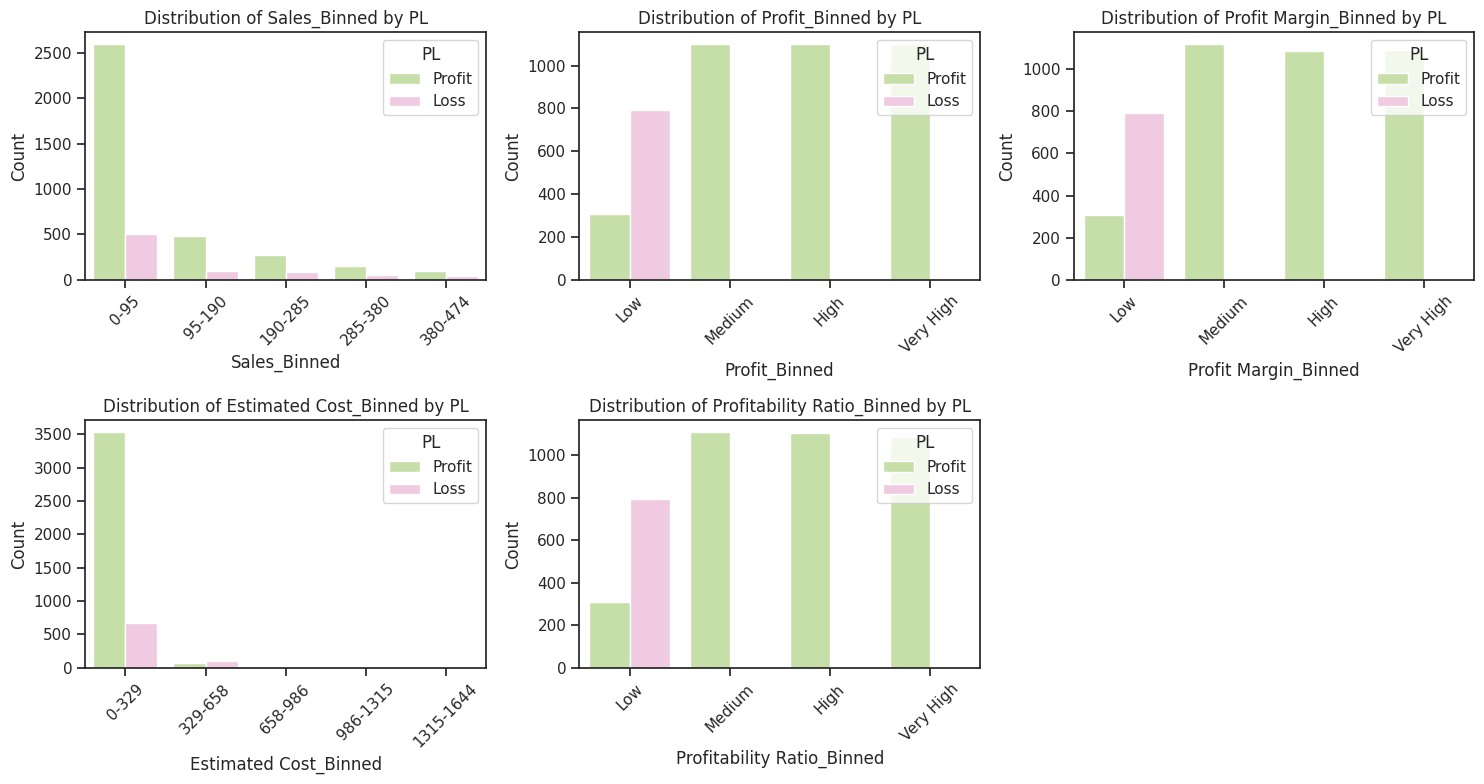

In [14]:
def plot_binned_distribution_grid(data, columns, hue="PL", grid_size=(2, 3)):
    """
    Plots count distributions for binned columns in a grid layout, colored by the 'hue' variable.

    Parameters:
    - data (pd.DataFrame): The dataset containing the binned columns to plot.
    - columns (list): List of binned columns to visualize.
    - hue (str): The categorical variable to color distributions by (default: 'PL').
    - grid_size (tuple): Number of rows and columns in the grid (default: (2,3)).
    """
    num_cols = len(columns)
    rows, cols = grid_size

    # Ensure grid is large enough for all columns
    fig, axes = plt.subplots(rows, cols, figsize=(15, 8))
    axes = axes.flatten()  # Flatten the grid for easy iteration

    # Loop through selected columns and plot countplot
    for i, col in enumerate(columns):
        if i < len(axes):  # Ensure we don’t exceed available axes
            sns.countplot(data=data, x=col, hue=hue, ax=axes[i], palette='PiYG_r')
            axes[i].set_title(f'Distribution of {col} by {hue}')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Count')
            axes[i].tick_params(axis='x', rotation=45)

    # Remove empty subplots if any
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Define final columns for KDE visualization
kde_columns = ['Sales_Binned', 'Profit_Binned', 'Profit Margin_Binned', 'Estimated Cost_Binned', 'Profitability Ratio_Binned']
sns.set_theme(style="ticks", context="notebook")
plot_binned_distribution_grid(data, kde_columns, hue="PL", grid_size=(2, 3))

### **📌 Evaluating Which Columns to Keep or Remove**
Now that we have **our transformed dataset with binned variables**, let's decide which columns to **keep for clustering** and which ones **to drop**.

---

### **🔹 Columns to Remove**
These columns **don’t contribute meaningful clustering insights** and should be **dropped**:

- **Row ID, Order ID, Product ID** transactional identifiers (not useful for clustering).
- **Customer ID, Customer Name**
- **City, State, Postal Code**: Too many unique values; may not add much clustering value.
- **Product Name**: Highly granular; not useful for clustering.
- **Sales_Customer, Profit_Customer**:Already reflected in `Sales_Binned` and `Profit_Binned`.

---

### **🔹 Should We Keep Time-Based Columns?**
📊 **Possible patterns**:
- **Do customers in different months/quarters behave differently?**  
- **Is there a seasonal effect on purchases?**  

**Approach**:
1. **Check distribution of sales/profit across time-based categories** (`Order Month`, `Order Quarter`, etc.).
2. If **time influences behavior**, we keep relevant features.
3. If **no strong patterns exist**, we remove time-based columns.

**What to look for**:
- **Significant variation in Sales/Profit across time?** → Keep the relevant columns.
- **No clear patterns?** → Drop the time-based columns.

---

### **📌 Final Column Selection for Clustering**
| Column | Keep? | Notes |
|---------|------|------------------------------------------------------|
| **Segment** | ✅ | Useful categorical variable for customer grouping. |
| **Region** | ✅ | May impact customer segmentation. |
| **Category, Sub-Category** | ✅ | Could help identify spending patterns by product type. |
| **Ship Mode** | ✅ | Could indicate high-priority customers. |
| **Sales_Binned, Profit_Binned, Profit Margin_Binned, Estimated Cost_Binned, Profitability Ratio_Binned** | ✅ | Key financial indicators. |
| **PL** | ✅ | Essential for clustering based on profit/loss. |
| **Discount** | ✅ | Left continuous as a key factor in spending behavior. |



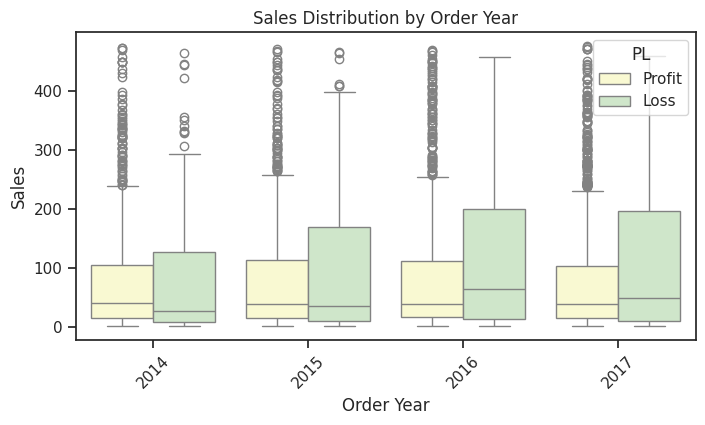

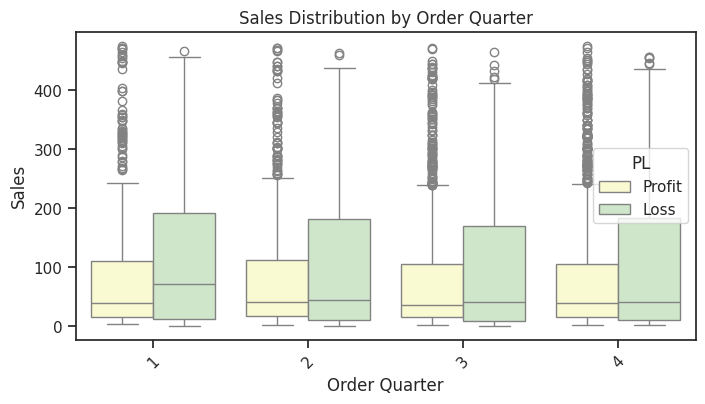

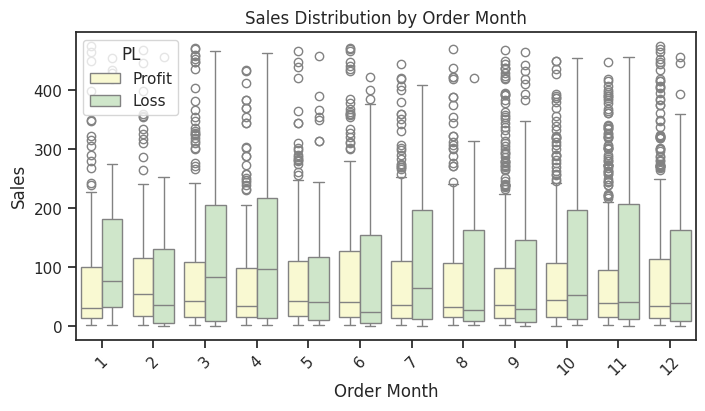

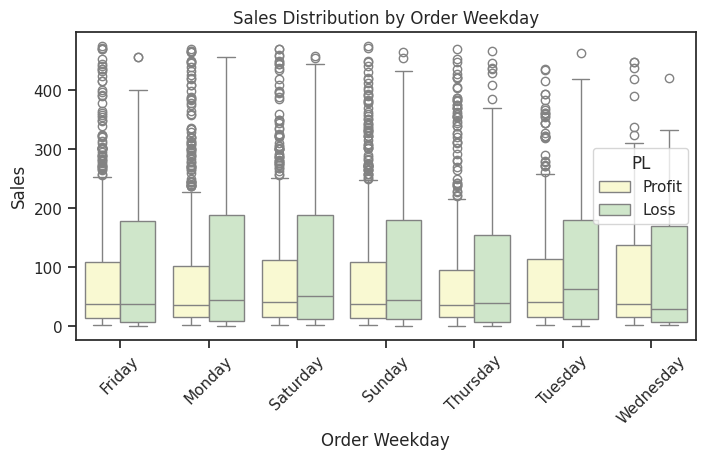

In [15]:

# check time-based columns for variation
time_columns = ['Order Year', 'Order Quarter', 'Order Month', 'Order Weekday']
for col in time_columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=data[col], y=data['Sales'], hue=data['PL'], palette='Pastel1_r')
    plt.title(f'Sales Distribution by {col}')
    plt.xticks(rotation=45)
    plt.show()


#### Data Utils Script

In [1]:
script_content=r'''

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def preprocess_data(data):
    """
    Prepares and preprocesses the Superstore dataset by cleaning, deriving core metrics,
    and converting appropriate columns to categorical types.
    """
    # Ensure the order and ship date columns are in datetime format
    data['Order Date'] = pd.to_datetime(data['Order Date'])
    data['Ship Date'] = pd.to_datetime(data['Ship Date'])

    # Derived Metrics
    # 1. Profit Margin
    data['Profit Margin'] = (data['Profit'] / data['Sales']) * 100

    # 2. Estimated Cost
    data['Estimated Cost'] = data['Sales'] - data['Profit']

    # 3. Profitability Ratio
    # Avoid division by zero errors by checking non-zero estimated cost
    data['Profitability Ratio'] = data.apply(
        lambda row: (row['Profit'] / row['Estimated Cost']) * 100 if row['Estimated Cost'] != 0 else 0,
        axis=1
    )

    # 4. Customer Metrics: Total Sales, Profit, and Order Count
    customer_metrics = data.groupby('Customer ID').agg({
        'Sales': 'sum',
        'Profit': 'sum',
        'Order ID': 'nunique'  # Number of orders
    }).rename(columns={'Order ID': 'Order Count'})

    # 5. Regional Market Share
    region_sales = data.groupby('Region')['Sales'].sum()
    total_sales = data['Sales'].sum()
    regional_market_share = (region_sales / total_sales) * 100

    # Merge customer metrics back to the main dataset
    data = data.merge(customer_metrics, on='Customer ID', suffixes=('', '_Customer'))
    data['Regional Market Share (%)'] = data['Region'].map(region_sales / total_sales * 100)

    # Convert relevant columns to categorical
    categorical_columns = ['Category', 'Sub-Category', 'Region', 'Segment', 'Ship Mode']
    for column in categorical_columns:
        data[column] = data[column].astype('category')

    return data


def convert_to_category_and_visualize(data, threshold=25, exclude_columns=None):
    """
    Converts columns with fewer than 'threshold' unique values to 'category' dtype,
    excluding specified columns, and visualizes the unique value counts.
    """
    if exclude_columns is None:
        exclude_columns = []

    # Count unique values for each column
    unique_counts = data.nunique()

    # Identify columns to convert, excluding specified columns
    columns_to_convert = [
        col for col in unique_counts[unique_counts < threshold].index
        if col not in exclude_columns
    ]

    # Convert selected columns to 'category' dtype
    for column in columns_to_convert:
        data[column] = data[column].astype('category')

    # Filter for columns with fewer than threshold unique values for visualization
    filtered_counts = unique_counts[
        (unique_counts < threshold) & (~unique_counts.index.isin(exclude_columns))
    ]

    # # Visualize unique value counts
    # palette = sns.color_palette("Pastel2", len(filtered_counts))
    # plt.figure(figsize=(9, 5))
    # filtered_counts.sort_values(ascending=False).plot(
    #     kind='bar',
    #     color=palette,
    #     edgecolor='black'
    # )
    # plt.title('Unique Value Counts for Columns Converted to Category', fontsize=14)
    # plt.xlabel('Columns', fontsize=12)
    # plt.ylabel('Number of Unique Categories', fontsize=12)
    # plt.xticks(rotation=45, ha='right', fontsize=10)
    # plt.grid(axis='y', linestyle='--', alpha=0.3)
    # plt.tight_layout()
    # plt.show()

    # Verify the conversions
    # print("\nColumns converted to 'category' dtype:")
    # for column in columns_to_convert:
    #     print(f"{column}: {data[column].dtype}")

    return data

def add_time_based_columns(data):
    """
    Adds time-based columns derived from Order Date and Ship Date to the dataset,
    and converts these columns to categorical type for analysis and visualization.
    """
    # Ensure the order and ship date columns are in datetime format
    data['Order Date'] = pd.to_datetime(data['Order Date'])
    data['Ship Date'] = pd.to_datetime(data['Ship Date'])

    # Create new time-based columns
    data['Order Year'] = data['Order Date'].dt.year
    data['Order Quarter'] = data['Order Date'].dt.quarter
    data['Order Month'] = data['Order Date'].dt.month
    data['Order Day'] = data['Order Date'].dt.day
    data['Order Weekday'] = data['Order Date'].dt.day_name()  # e.g., 'Monday', 'Tuesday'

    data['Ship Month'] = data['Ship Date'].dt.month
    data['Ship Day'] = data['Ship Date'].dt.day
    data['Ship Weekday'] = data['Ship Date'].dt.day_name()

    # Convert the new columns to categorical
    time_columns = ['Order Year', 'Order Month', 'Order Month', 'Order Day', 'Order Weekday', 'Ship Month', 'Ship Day', 'Ship Weekday']
    for column in time_columns:
        data[column] = data[column].astype('category')

    return data

def standardize_categorical_columns(data, columns=None):
    """
    Standardizes categorical columns by converting their values to title case.
    If `columns` is None, all categorical columns are standardized.
    """
    if columns is None:
        columns = data.select_dtypes(include='category').columns

    for column in columns:
        if column in data.columns:
            data[column] = data[column].astype(str).str.title().astype('category')
    return data


def remove_duplicates(data, subset=None):
    """
    Removes duplicate rows from the dataset and reports the number of rows removed.

    Parameters:
    - data: DataFrame
        The dataset to remove duplicates from.
    - subset: list or None, optional
        Columns to consider for identifying duplicates. If None, all columns are used.

    Returns:
    - DataFrame: A new DataFrame with duplicates removed.
    """
    initial_shape = data.shape
    # Drop duplicates using the provided subset or across all columns if subset is None
    data = data.loc[~data.duplicated(subset=subset)].copy()
    removed_rows = initial_shape[0] - data.shape[0]
    print(f"Removed {removed_rows} duplicate rows.")
    return data


def calculate_aggregate_metrics(data, group_by_columns):
    """
    Dynamically calculates aggregate metrics for specified groupings.

    Parameters:
    - data: DataFrame
        The dataset to calculate metrics from.
    - group_by_columns: list
        The columns to group the data by.

    Returns:
    - DataFrame: A new DataFrame with the aggregated metrics.
    """
    # Define the aggregation columns and their operations
    aggregation_columns = {
        'Profit': 'sum',
        'Profit Margin': 'mean',
        'Profitability Ratio': 'mean',  # New metric
        'Estimated Cost': 'sum',
        'Sales': 'sum',
        'Discount': 'mean',
        'Order Count': 'sum',
        'Quantity': 'sum',
        'Regional Market Share (%)': 'mean'  # New metric
    }

    # Perform the group-by operation and apply aggregations
    aggregated_data = data.groupby(group_by_columns, observed=True).agg(**{
        f"Total_{key.replace(' ', '_')}": (key, agg_func)
        for key, agg_func in aggregation_columns.items()
    })

    # Reset index for better readability
    aggregated_data = aggregated_data.reset_index()

    return aggregated_data

def detect_outliers_tukey(data, column):
    """
    Detects outliers using Tukey's Fences method for a specified column.

    Parameters:
    - data: DataFrame
        The dataset to analyze.
    - column: str
        The column for which to detect outliers.

    Returns:
    - non_outliers: DataFrame
        Subset of data without outliers.
    - outliers: DataFrame
        Subset of data containing outliers.
    """
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_fence = Q1 - 1.5 * IQR
    upper_fence = Q3 + 1.5 * IQR

    non_outliers = data[(data[column] >= lower_fence) & (data[column] <= upper_fence)]
    outliers = data[(data[column] < lower_fence) | (data[column] > upper_fence)]

    return non_outliers, outliers


# Function to label outliers using Tukey's Fences
def label_outliers_tukey(data, column):
    """
    Labels outliers in the specified column using Tukey's Fences method.

    Parameters:
    - data: DataFrame
        The dataset to analyze.
    - column: str
        The column for which to detect and label outliers.

    Returns:
    - DataFrame
        Dataset with an additional column indicating "Outlier" or "Inlier".
    """
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_fence = Q1 - 1.5 * IQR
    upper_fence = Q3 + 1.5 * IQR

    # Labeling each row
    outlier_label = data[column].apply(
        lambda x: 'Outlier' if (x < lower_fence or x > upper_fence) else 'Inlier'
    )

    # Adding the label column
    data[f'{column}_Outlier'] = outlier_label

    return data



def remove_outliers_tukey(data, column, plot=True):
    """
    Removes outliers from a specified column in the dataset using Tukey's Fences (IQR Method),
    and optionally plots the data before and after outlier removal.

    Parameters:
    - data (DataFrame): The input dataset.
    - column (str): The column on which to perform outlier detection.
    - plot (bool): Whether to plot boxplots for the original and filtered data.

    Returns:
    - filtered_data (DataFrame): Dataset without outliers.
    - outliers (DataFrame): Outlier data points.

    Example:
        filtered_data, outliers = remove_outliers_tukey(data, column='Sales', plot=True)

    Notes:
        - This function uses Tukey's Fences (IQR method) to detect and remove outliers.
        - Suitable for continuous numeric data with potential outliers.
    """
    # Compute Q1, Q3, and IQR
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define fences
    lower_fence = Q1 - 1.5 * IQR
    upper_fence = Q3 + 1.5 * IQR

    # Filter data
    filtered_data = data[(data[column] >= lower_fence) & (data[column] <= upper_fence)].copy()
    outliers = data[(data[column] < lower_fence) | (data[column] > upper_fence)].copy()

    # Print summary
    print(f"Column: {column}")
    print(f"Lower Fence: {lower_fence:.2f}, Upper Fence: {upper_fence:.2f}")
    print(f"Original Dataset: {len(data)} rows")
    print(f"Non-Outliers: {len(filtered_data)} rows ({len(filtered_data) / len(data) * 100:.2f}%)")
    print(f"Outliers: {len(outliers)} rows ({len(outliers) / len(data) * 100:.2f}%)")

    # Plotting
    if plot:
        sns.set_theme(style="whitegrid", context="notebook")

        # Plot original data
        if len(data) > 0:
            plt.figure(figsize=(8, 3))
            sns.boxplot(x=data[column], color='darkorange')
            plt.title(f"Original {column} Distribution (With Outliers)", fontsize=14)
            plt.xlabel(column, fontsize=12)
            plt.tight_layout()
            plt.show()

        # Plot filtered data
        if len(filtered_data) > 0:
            plt.figure(figsize=(8, 3))
            sns.boxplot(x=filtered_data[column], color='pink')
            plt.title(f"Filtered {column} Distribution (Without Outliers)", fontsize=14)
            plt.xlabel(column, fontsize=12)
            plt.tight_layout()
            plt.show()

    return filtered_data, outliers


'''

with open("data_prep_utils.py", "w") as file:
    file.write(script_content)

print("Script successfully written to data_prep_utils.py")

# Import and reload the module to use its functions
import importlib
import data_prep_utils as dpu
importlib.reload(dpu)



Script successfully written to data_prep_utils.py


<module 'data_prep_utils' from '/content/data_prep_utils.py'>

#### Data Visualization Script

In [2]:
script_content=r'''

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def plot_sales_distribution(data, column='Sales', title='Sales Distribution Visualizations', color='lightgreen'):
    """
    Visualizes the distribution of a specified column with a barplot, boxplot, and histogram (with KDE).

    Args:
        data (pd.DataFrame): The dataset containing the sales data.
        column (str): The column to visualize. Default is 'Sales'.
        title (str): The title for the overall plot.
        color (str): The color for the visualizations. Default is 'lightgreen'.

    Returns:
        None: Displays the plots directly.
    """
    # Set Seaborn theme
    sns.set_theme(style="ticks", context="talk")

    # Create the figure and subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 6), gridspec_kw={'width_ratios': [1, 1, 2]})

    # Barplot: Total sales
    total_value = data[column].sum()
    sns.barplot(x=[column], y=[total_value], color=color, edgecolor='k', ax=axes[0])
    axes[0].set_title(f"Total {column} (Barplot)", fontsize=14)
    axes[0].set_xlabel("")
    axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"${x:,.0f}"))

    # Boxplot: Distribution of sales
    sns.boxplot(y=data[column], color=color, showfliers=True, ax=axes[1], linecolor='k')
    axes[1].set_title(f"{column} Distribution (Boxplot)", fontsize=14)
    axes[1].set_xlabel(column)
    axes[1].set_ylabel("")

    # Histogram with KDE: Overall sales distribution
    sns.histplot(data=data, x=column, kde=True, color=color, ax=axes[2])
    axes[2].set_title(f"{column} Distribution (Histogram + KDE)", fontsize=14)
    axes[2].set_xlabel(column, fontsize=12)
    axes[2].set_ylabel("Frequency", fontsize=12)
    axes[2].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:,.0f}"))
    axes[2].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"${x:,.0f}"))

    # Adjust layout
    plt.tight_layout()
    plt.suptitle(title, fontsize=20, y=1.03)
    plt.show()

def plot_sales_distribution_2(data, column='Sales', title='Distribution Visualizations', color='lightgreen', round_decimals=None):
    """
    Visualizes the distribution of a specified column with a barplot, boxplot, and histogram (with KDE).

    Args:
        data (pd.DataFrame): The dataset containing the data.
        column (str): The column to visualize. Default is 'Sales'.
        title (str): The title for the overall plot.
        color (str): The color for the visualizations. Default is 'lightgreen'.
        round_decimals (int, optional): Number of decimal places to round the x-axis values. Default is None.

    Returns:
        None: Displays the plots directly.
    """
    # Set Seaborn theme
    sns.set_theme(style="ticks", context="talk")

    # Create the figure and subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 6), gridspec_kw={'width_ratios': [1, 1, 2]})

    # Barplot: Total value
    total_value = data[column].sum()
    sns.barplot(x=[column], y=[total_value], color=color, edgecolor='k', ax=axes[0])
    axes[0].set_title(f"Total {column} (Barplot)", fontsize=14)
    axes[0].set_xlabel("")
    axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"${x:,.0f}"))

    # Boxplot: Distribution of the column
    sns.boxplot(y=data[column], color=color, showfliers=True, ax=axes[1], linecolor='k')
    axes[1].set_title(f"{column} Distribution (Boxplot)", fontsize=14)
    axes[1].set_xlabel(column)
    axes[1].set_ylabel("")

    # Histogram with KDE: Dynamic x-axis
    sns.histplot(data=data, x=column, kde=True, color=color, ax=axes[2])
    axes[2].set_title(f"{column} Distribution (Histogram + KDE)", fontsize=14)
    axes[2].set_xlabel(column, fontsize=12)
    axes[2].set_ylabel("Frequency", fontsize=12)

    # Automatically format x-axis based on the data range
    x_max = data[column].max()
    x_min = data[column].min()
    x_ticks = plt.MaxNLocator(nbins=6).tick_values(x_min, x_max)

    # Round x-axis values if specified
    if round_decimals is not None:
        x_ticks = [round(tick, round_decimals) for tick in x_ticks]
        axes[2].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:,.0f}" if round_decimals == 0 else f"{x:,.{round_decimals}f}"))

    axes[2].xaxis.set_ticks(x_ticks)

    # Adjust layout
    plt.tight_layout()
    plt.suptitle(title, fontsize=20, y=1.03)
    # plt.show()


# Define a function to calculate summary statistics for a given column
def calculate_discount_stats(data, column='Discount'):
    """
    Calculates summary statistics for a specific column in the given dataset.

    Args:
        data (pd.DataFrame): The dataset to calculate statistics from.
        column (str): The column to calculate statistics for.

    Returns:
        dict: A dictionary of summary statistics.
    """
    stats = {
        'Min': data[column].min(),
        'Max': data[column].max(),
        'Mean': data[column].mean(),
        'Median': data[column].median(),
        'Standard Deviation': data[column].std()
    }
    return stats

def plot_discount_summary(discount_summary_table, title="Summary Statistics for Discounts"):
    """
    Plots a grouped barplot for discount summary statistics.

    Args:
        discount_summary_table (pd.DataFrame): DataFrame containing summary statistics for discounts.
        title (str): Title for the plot.

    Returns:
        None: Displays the barplot.
    """
    # Melt the DataFrame to long format for easier plotting with Seaborn
    discount_summary_melted = discount_summary_table.melt(
        id_vars='Statistic',
        var_name='Group',
        value_name='Value'
    )

    # Set Seaborn theme
    sns.set_theme(style="whitegrid", context="talk")

    # Create the barplot
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=discount_summary_melted,
        x='Statistic',
        y='Value',
        hue='Group',
        palette=['red', 'green']
    )

    # Add titles and labels
    plt.title(title, fontsize=18)
    plt.xlabel("Statistic", fontsize=14)
    plt.ylabel("Value", fontsize=14)
    plt.legend(title="Group", fontsize=12, title_fontsize=14)

    # Adjust layout
    plt.tight_layout()
    # plt.show()


def plot_discount_kde(data_losses, data_profits, column='Discount', title='Plot for Costs'):
    """
    Plots overlaying KDE plots for discounts in profitable and non-profitable datasets.

    Args:
        data_losses (pd.DataFrame): Dataset with losses (Profit < 0).
        data_profits (pd.DataFrame): Dataset with profits (Profit >= 0).
        column (str): The column to visualize. Default is 'Discount'.
        title (str): Title for the overall plot.

    Returns:
        None: Displays the KDE plot.
    """
    # Set Seaborn theme
    sns.set_theme(style="ticks", context="talk")

    # Create the KDE plot
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=data_losses[column], fill=True, color="red", alpha=0.5, label="Losses (Profit < 0)", linewidth=2)
    sns.kdeplot(data=data_profits[column], fill=True, color="green", alpha=0.5, label="Profits (Profit >= 0)", linewidth=2)

    # Add titles and labels
    plt.title(title, fontsize=18)
    plt.xlabel(column, fontsize=14)
    plt.ylabel("Density", fontsize=14)

    # Add legend
    plt.legend(title="Group", fontsize=12, title_fontsize=14)

    # Show the plot
    plt.tight_layout()
    # plt.show()

def plot_discount_boxplot(data_losses, data_profits, column='Discount', title='Boxplot for Costs'):
    """
    Plots side-by-side boxplots for costs in profitable and non-profitable datasets.

    Args:
        data_losses (pd.DataFrame): Dataset with losses (Profit < 0).
        data_profits (pd.DataFrame): Dataset with profits (Profit >= 0).
        column (str): The column to visualize. Default is 'Discount'.
        title (str): Title for the overall plot.

    Returns:
        None: Displays the boxplot.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd

    # Create copies of the data to avoid SettingWithCopyWarning
    data_losses_copy = data_losses.copy()
    data_profits_copy = data_profits.copy()

    # Add group labels
    data_losses_copy['Group'] = 'Losses (Profit < 0)'
    data_profits_copy['Group'] = 'Profits (Profit >= 0)'

    # Combine datasets for boxplot
    combined_data = pd.concat([data_losses_copy, data_profits_copy], ignore_index=True)

    # Create the boxplot
    plt.figure(figsize=(8, 6))
    sns.boxplot(
        data=combined_data,
        x='Group',
        y=column,
        hue='Group',
        palette={"Losses (Profit < 0)": "red", "Profits (Profit >= 0)": "green"},
        showfliers=True
    )

    # Add titles and labels
    plt.title(title, fontsize=18)
    plt.xlabel("Group", fontsize=14)
    plt.ylabel(column, fontsize=14)

    # Remove legend for simplicity
    plt.legend([], [], frameon=False)

    # Show the plot
    plt.tight_layout()
    # plt.show()

def calculate_stats(data, column, **kwargs):
    """
    Calculate descriptive statistics for a given column and return selected metrics.

    Args:
        data (pd.DataFrame): The dataset.
        column (str): Column name for which to calculate statistics.
        kwargs: Keyword arguments specifying which statistics to calculate.

    Returns:
        dict: Dictionary of selected descriptive statistics.
    """
    stats = {}

    # Calculate all available statistics
    all_stats = {
        "min": data[column].min(),
        "median": data[column].median(),
        "mean": data[column].mean(),
        "mode": data[column].mode().iloc[0],  # First mode
        "std": data[column].std(),
        "max": data[column].max(),
        "range": data[column].max() - data[column].min()
    }

    # Filter based on kwargs or include all if no kwargs specified
    if not kwargs:
        stats = all_stats  # Return all stats if no specific arguments provided
    else:
        stats = {stat: all_stats[stat] for stat, include in kwargs.items() if include}

    return stats

def plot_descriptive_stats(stats, column_name, color_palette="Pastel2"):
    """
    Visualizes descriptive statistics as a horizontal barplot, with the column name in the title.

    Args:
        stats (dict): Dictionary of descriptive statistics where keys are statistic names and values are their numeric values.
        column_name (str): Name of the column the statistics represent (e.g., 'Sales', 'Profit').
        color_palette (str): Seaborn color palette for the bars. Default is "Pastel2".

    Returns:
        None: Displays the plot directly.
    """

    # Convert stats dictionary to DataFrame
    stats_df = pd.DataFrame(stats.items(), columns=["Statistic", "Value"])

    # Create the horizontal barplot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        data=stats_df,
        y="Statistic",  # Use y-axis for categories
        x="Value",  # Use x-axis for values
        hue="Statistic", palette=color_palette,
        edgecolor="black"
    )

    # Add value annotations to each bar
    for index, row in stats_df.iterrows():
        ax.text(
            row["Value"] + 5,  # Slightly offset to the right of the bar
            index,  # Position at the center of the bar
            f"${row['Value']:,.2f}",  # Format with full value
            va="center",  # Center vertically
            ha="left",  # Align text to the left of the bar
            fontsize=12
        )

    # Add labels and title
    plt.title(f"Descriptive Statistics for {column_name}", fontsize=16)
    plt.xlabel("Value", fontsize=12)
    plt.ylabel("")
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"${x:,.0f}"))
    plt.tight_layout()
    # plt.show()

def plot_discount_analysis_grid(data_losses, data_profits, summary_table, column='Discount'):
    """
    Creates a grid of plots for discount analysis, including:
    - A barplot of summary statistics
    - A KDE plot of discount distributions
    - A boxplot comparing discounts by profitability.

    Args:
        data_losses (pd.DataFrame): Dataset with losses (Profit < 0).
        data_profits (pd.DataFrame): Dataset with profits (Profit >= 0).
        summary_table (pd.DataFrame): Summary statistics table for discounts.
        column (str): The column to analyze. Default is 'Discount'.

    Returns:
        None: Displays the plots.
    """
    import pandas as pd
    import matplotlib.gridspec as gridspec

    # Create copies to avoid warnings
    data_losses_copy = data_losses.copy()
    data_profits_copy = data_profits.copy()

    # Add group labels
    data_losses_copy['Group'] = 'Losses (Profit < 0)'
    data_profits_copy['Group'] = 'Profits (Profit >= 0)'

    # Combine datasets for boxplot
    combined_data = pd.concat([data_losses_copy, data_profits_copy], ignore_index=True)

    # Set up the grid layout
    fig = plt.figure(figsize=(14, 10))
    gs = gridspec.GridSpec(2, 2, width_ratios=[2,1], height_ratios=[1, 1], hspace=0.3, wspace=0.2)

    # Plot 1: Summary statistics barplot
    ax1 = fig.add_subplot(gs[0, 0])
    sns.barplot(
        data=summary_table.melt(id_vars=['Statistic'], var_name='Group', value_name='Value'),
        x='Statistic',
        y='Value',
        hue='Group',
        palette={"Losses (Profit < 0)": "red", "Profits (Profit >= 0)": "green"},
        ax=ax1
    )
    ax1.set_title("Summary Statistics for Costs", fontsize=14)
    ax1.set_ylabel("Value", fontsize=12)
    ax1.set_xlabel("Statistic", fontsize=12)
    ax1.legend(title="Group", fontsize=10, title_fontsize=12)

    # Plot 2: KDE plot
    ax2 = fig.add_subplot(gs[1,0])
    sns.kdeplot(data=data_losses[column], fill=True, color="red", alpha=0.5, label="Losses (Profit < 0)", ax=ax2, linewidth=2)
    sns.kdeplot(data=data_profits[column], fill=True, color="green", alpha=0.5, label="Profits (Profit >= 0)", ax=ax2, linewidth=2)
    ax2.set_title("Cost Distributions", fontsize=14)
    ax2.set_xlabel(column, fontsize=12)
    ax2.set_ylabel("Density", fontsize=12)
    ax2.legend(title="Group", fontsize=10, title_fontsize=12)

    # Plot 3: Boxplot
    ax3 = fig.add_subplot(gs[:,1])
    sns.boxplot(
        data=combined_data,
        x='Group',
        y=column,
        hue='Group',
        palette={"Losses (Profit < 0)": "red", "Profits (Profit >= 0)": "green"},
        ax=ax3,
        showfliers=True
    )
    ax3.set_title("Discount by Profitability", fontsize=14)
    ax3.set_xlabel("Group", fontsize=12)
    ax3.set_ylabel(column, fontsize=12)
    ax3.legend([], [], frameon=False)  # Remove redundant legend

    # Adjust layout and display the grid
    # plt.tight_layout()
    # plt.show()

def plot_metrics_grid(data1, data2=None, metrics=None, group_by_column="", title_prefix="", palette="Greens_d", figsize=(15, 12)):
    """
    Plots a grid of barplots for single or multiple datasets with multiple metrics.

    Args:
        data1 (pd.DataFrame): Primary dataset.
        data2 (pd.DataFrame, optional): Secondary dataset for comparison. Defaults to None.
        metrics (list): List of column names to plot.
        group_by_column (str): Column to group by on the x-axis.
        title_prefix (str): Prefix for each plot's title.
        palette (str): Seaborn color palette.
        figsize (tuple): Size of the figure (width, height).

    Returns:
        None: Displays the plots.
    """

    datasets = [data1] if data2 is None else [data1, data2]
    titles = [""] if data2 is None else ["Dataset 1", "Dataset 2"]

    # Determine grid size
    n_cols = 3
    n_rows = -(-len(metrics) * len(datasets) // n_cols)  # Ceiling division
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()

    for i, metric in enumerate(metrics or []):
        for j, (data, title_suffix) in enumerate(zip(datasets, titles)):
            idx = i * len(datasets) + j
            if idx < len(axes):
                sns.barplot(
                    data=data.sort_values(by=metric, ascending=False),
                    x=group_by_column,
                    y=metric,
                    hue=metric, palette=palette, legend=False, dodge=False,
                    ax=axes[idx]
                )
                axes[idx].set_title(f"{title_prefix}{metric.replace('_', ' ')} {title_suffix}")
            else:
                axes[idx].axis('off')

    plt.tight_layout()
    # plt.show()

def plot_discount_loss_grid_1x2(data, group_by_columns, discount_column, profit_column, palette1, palette2, order_by, save_path_template=None, figsize=(14, 6)):
    """
    Plots discount and profit side by side for each group in a 1x2 grid, dynamically adapting palettes and sorting.

    Parameters:
        data (pd.DataFrame): Dataset to plot.
        group_by_columns (list): Columns to group by (e.g., ['Region', 'State']).
        discount_column (str): Column name for discount data.
        profit_column (str): Column name for profit data.
        palette1 (str): Name of the palette for profit.
        palette2 (str): Name of the palette for discount.
        order_by (str): Column to sort by within each group (e.g., 'Total_Profit').
        save_path_template (str): Template for saving plots (e.g., "/path/to/{group}_plot.png").
        figsize (tuple): Figure size for the plots.

    Returns:
        None: Displays the plots and saves them to files if `save_path_template` is provided.
    """
    # Aggregate data for the given group_by_columns
    grouped_data = data.groupby(group_by_columns, observed=True).sum().reset_index()

    # Extract unique group values for looping
    unique_groups = grouped_data[group_by_columns[0]].unique()

    for group in unique_groups:
        # Filter data for the current group
        filtered_data = grouped_data[grouped_data[group_by_columns[0]] == group]

        # Sort the data by the specified column
        filtered_data = filtered_data.sort_values(by=order_by, ascending=True)

        # Calculate number of unique categories
        n_cats = filtered_data[group_by_columns[-1]].nunique()

        # Dynamically generate palettes
        p1 = sns.color_palette(palette1, n_colors=n_cats + 2)[:n_cats]  # Avoid light colors
        p2 = sns.color_palette(palette2, n_colors=n_cats + 2)[-n_cats:]  # Avoid light colors

        # Set up the grid for side-by-side plots
        fig, axes = plt.subplots(1, 2, figsize=figsize)

        # Plot profit (left)
        sns.barplot(
            data=filtered_data,
            x=profit_column,
            y=group_by_columns[1],
            hue=filtered_data[profit_column],
            palette=p1,
            order=filtered_data[group_by_columns[1]],
            legend=False,
            dodge=False,
            ax=axes[0]
        )
        axes[0].set_title(f"{group} - Total Profit", fontsize=14)
        axes[0].set_xlabel("Total Profit", fontsize=12)
        axes[0].set_ylabel(group_by_columns[1].replace('_', ' '), fontsize=12)

        # Plot discount (right)
        sns.barplot(
            data=filtered_data,
            x=discount_column,
            y=group_by_columns[1],
            hue=filtered_data[discount_column],
            palette=p2,
            order=filtered_data[group_by_columns[1]],
            legend=False,
            dodge=False,
            ax=axes[1]
        )
        axes[1].set_title(f"{group} - Average Discount", fontsize=14)
        axes[1].set_xlabel("Average Discount", fontsize=12)
        axes[1].set_ylabel("")  # No need for y-axis label on the second plot

        # Adjust layout
        plt.tight_layout()

        # Save the plot if a save path template is provided
        if save_path_template:
            save_path = save_path_template.format(group=group.replace(" ", "_"))
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            # print(f"Figure saved as {save_path}")
            print('\n')

        # Show the plot
        plt.show()



def plot_category_subcategory_loss_grid_with_region(data, category_column, sub_category_column, region_column,
                                                    discount_column, profit_column, title='Category:',
                                                    palette1='Reds', palette2='Reds_r', figsize=(14, 6)):
    """
    Plots profit and discount side by side for each sub-category grouped by category and region.

    Parameters:
        data (pd.DataFrame): Dataset to plot.
        category_column (str): Column name for category.
        sub_category_column (str): Column name for sub-category.
        region_column (str): Column name for region.
        discount_column (str): Column name for discount data.
        profit_column (str): Column name for profit data.
        palette1 (str): Seaborn palette for the profit plot.
        palette2 (str): Seaborn palette for the discount plot.
        figsize (tuple): Figure size for the plots.

    Returns:
        None: Displays the plots.
    """
    if data.empty:
        print(f"No data available for plotting in region: {title}")
        return

    # Sort the data by profit to determine the order
    data_sorted = data.sort_values(by=profit_column, ascending=True)

    # Calculate unique subcategories for dynamic palette sizing
    n_cats = data_sorted[sub_category_column].nunique()

    # Generate palettes dynamically
    custom_palette_1 = sns.color_palette(palette1, n_colors=n_cats + 2)[2:]  # Avoid light colors
    custom_palette_2 = sns.color_palette(palette2, n_colors=n_cats + 3)[3:]  # Avoid light colors

    # Set up the grid for side-by-side plots
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # Plot Profit (left)
    sns.barplot(
        data=data_sorted,
        x=profit_column,
        y=sub_category_column,
        order=data_sorted[sub_category_column],
        hue=data_sorted[profit_column],
        palette=custom_palette_1,
        legend=False,
        dodge=False,
        ax=axes[0]
    )
    axes[0].set_title("Loss by Sub-Category and Region", fontsize=14)
    axes[0].set_xlabel(profit_column, fontsize=12)
    axes[0].set_ylabel(sub_category_column.replace('_', ' '), fontsize=12)

    # Plot Discount (right)
    sns.barplot(
        data=data_sorted,
        x=discount_column,
        y=sub_category_column,
        order=data_sorted[sub_category_column],
        hue=data_sorted[discount_column],
        palette=custom_palette_2,
        legend=False,
        dodge=False,
        ax=axes[1]
    )
    axes[1].set_title("Discount by Sub-Category and Region", fontsize=14)
    axes[1].set_xlabel(discount_column, fontsize=12)
    axes[1].set_ylabel("")  # No need for y-axis label on the second plot

    # Adjust layout
    plt.suptitle(f"Category: {title}", fontsize=16)
    plt.tight_layout()
    plt.show()

def plot_kde_grid(data, columns, hue="PL", grid_size=(2, 3)):
    """
    Plots KDE distributions for multiple columns in a grid layout, colored by the 'hue' variable.

    Parameters:
    - data (pd.DataFrame): The dataset containing the columns to plot.
    - columns (list): List of numeric columns to visualize.
    - hue (str): The categorical variable to color distributions by (default: 'PL').
    - grid_size (tuple): Number of rows and columns in the grid (default: (2,3)).
    """
    num_cols = len(columns)
    rows, cols = grid_size

    # Ensure grid is large enough for all columns
    fig, axes = plt.subplots(rows, cols, figsize=(15, 8))
    axes = axes.flatten()  # Flatten the grid for easy iteration

    # Loop through selected columns and plot KDE
    for i, col in enumerate(columns):
        if i < len(axes):  # Ensure we don’t exceed available axes
            sns.kdeplot(data=data, x=col, hue=hue, fill=True, common_norm=False, ax=axes[i], palette='PiYG_r')
            axes[i].set_title(f'Distribution of {col} by {hue}')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Density')

    # Remove empty subplots if any
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
'''

with open("data_visualization_utils.py", "w") as file:
    file.write(script_content)

print("Script successfully written to data_visualization_utils.py")

# Import and reload the module to use its functions
import importlib
import data_visualization_utils as dvu
importlib.reload(dvu)

Script successfully written to data_visualization_utils.py


<module 'data_visualization_utils' from '/content/data_visualization_utils.py'>